In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

from scipy.stats import zscore
# from scipy.io import wavfile

# from sklearn.model_selection import KFold
# from sklearn.model_selection import ParameterGrid
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
#
# from sklearn.ensemble import RandomForestClassifier
#
# from sklearn.metrics import accuracy_score,\
#                             confusion_matrix, \
#                             precision_score, \
#                             recall_score, \
#                             f1_score, \
#                             classification_report


from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, \
                            r2_score

from prettytable import PrettyTable

In [2]:
DATA_PATH_SUMMARY = './weatherww2/SummaryofWeather.csv'
DATA_PATH_SENSORS = './weatherww2/WeatherStationLocations.csv'
fields = ['STA', 'Date', 'MaxTemp', 'MinTemp', 'MeanTemp']

In [3]:
def load_data(data_path):

    dataset = pd.read_csv(data_path[0], header=0, low_memory=False)
    sensors = pd.read_csv(data_path[1], header=0, low_memory=False)
    return dataset, sensors


In [4]:
dataset, sensors_ds = load_data((DATA_PATH_SUMMARY, DATA_PATH_SENSORS))
dataset.info()

# no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  object 
 2   Precip       119040 non-null  object 
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  object 
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SNF          117877 non-

In [5]:
sensors_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WBAN              161 non-null    int64  
 1   NAME              161 non-null    object 
 2   STATE/COUNTRY ID  161 non-null    object 
 3   LAT               161 non-null    object 
 4   LON               161 non-null    object 
 5   ELEV              161 non-null    int64  
 6   Latitude          161 non-null    float64
 7   Longitude         161 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 10.2+ KB


In [6]:
dataset.groupby("STA").size().sort_values(0, ascending=False).head(10)

# Grouping the rows by sensor id (STA), counting the size of each group, and, finally, sorting them
# gives us the list of STAs that show up the most.

STA
22508    2192
10701    2185
22502    2154
22504    2118
10803    1750
11610    1631
16405    1622
11601    1604
10502    1527
11604    1514
dtype: int64

In [7]:
dataset["Date"] = pd.to_datetime(dataset["Date"])
df = dataset.set_index("Date")

In [8]:
# We can now keep only the readings of Sensor 22508 and plot the series of MeanTemps

mtemps = df[df["STA"] == 22508]["MeanTemp"]
mtemps.head(5)

Date
1940-01-01    20.000000
1940-01-02    19.444444
1940-01-03    20.000000
1940-01-04    21.111111
1940-01-05    18.333333
Name: MeanTemp, dtype: float64

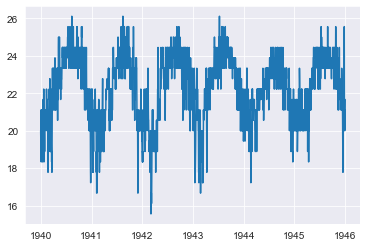

In [9]:
fig, ax = plt.subplots()
_ = ax.plot(mtemps.index.values, mtemps.values)

# I will use the values in a window of fixed-length W. Specifically, this
# window will be rolling along the series, to obtain one record for each time step

# - target variable: to model the task of forecasting, the target variable should encode a future event.
# Thus, the algorithm will be able to model the relationship between some already-seen feature values
# and an upcoming behavior of the series.

In [11]:
W = 3
X = list()
y = list()

for i in range(mtemps.size - W): # range: [0, mtemps.size - W - 1]
    X.append(mtemps.iloc[i:i + W].values.T) # transpose to create a row array
    y.append(mtemps.iloc[i + W])

# transform the structured representation into numpy arrays
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((2189, 3), (2189,))

In [12]:
print(mtemps[:6])
print(X[:3,:])

Date
1940-01-01    20.000000
1940-01-02    19.444444
1940-01-03    20.000000
1940-01-04    21.111111
1940-01-05    18.333333
1940-01-06    20.000000
Name: MeanTemp, dtype: float64
[[20.         19.44444444 20.        ]
 [19.44444444 20.         21.11111111]
 [20.         21.11111111 18.33333333]]


In [13]:
X_df = pd.DataFrame(X, index=mtemps.index[:mtemps.size - W], columns=["t0", "t1", "t2"])
X_df.head()

,t0,t1,t2
Date,,,
1940-01-01,20.000000,19.444444,20.000000
1940-01-02,19.444444,20.000000,21.111111
1940-01-03,20.000000,21.111111,18.333333
1940-01-04,21.111111,18.333333,20.000000
1940-01-05,18.333333,20.000000,20.555556


In [14]:
y_s = pd.Series(y, index=mtemps.index[:mtemps.size - W])
y_s.head()

Date
1940-01-01    21.111111
1940-01-02    18.333333
1940-01-03    20.000000
1940-01-04    20.555556
1940-01-05    18.888889
dtype: float64

In [15]:
X_train, y_train = X_df.loc["1940":"1944"], y_s.loc["1940":"1944"]

# since i used a forward-looking notation for the window, i.e. for the record t we have
# the values of the series between t and t+W. Under this conditions, at the end of the year, i'll be
# going to have W data points that include information from the next year. This is not a problem
# up if i slightly shift the beginning of our test set. Specifically, i might want to start the test
# set for the Wth day or the year.
'''
Including some information from what it is consider the test set into the training procedure is a
wrong habit known as data leakage.
'''
# You should always stop and take a moment to consider if
# any data leakage is happening within your pipeline.

In [17]:
initial_day = date(1944, 12, 31) + pd.Timedelta(f"{W} days")
initial_day

datetime.date(1945, 1, 3)

In [18]:
X_test, y_test = X_df.loc[initial_day:], y_s.loc[initial_day:]

X_test.shape, y_test.shape

((360, 3), (360,))

more complex and useful indexings are possibile

https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [19]:
def get_models(degree):
    models = [LinearRegression(),
              Ridge(random_state=42),
              MLPRegressor(hidden_layer_sizes=(10,), random_state=42, max_iter=10000),
              MLPRegressor(hidden_layer_sizes=(10,10), activation='tanh', solver='lbfgs',
                           alpha=0.000, batch_size='auto', learning_rate='constant',learning_rate_init=0.01,
                           power_t=0.5, max_iter=10000, shuffle=True, momentum=0.0, nesterovs_momentum=False,
                           early_stopping=False, validation_fraction=0.0, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              SVR(gamma='scale'),
              RandomForestRegressor(n_estimators=300),
              make_pipeline(
                  make_column_transformer(
                      (FunctionTransformer(np.sin), [0]),
                      (PolynomialFeatures(degree), [0])
                  ),
                  LinearRegression()
              ),
              make_pipeline(
                  make_column_transformer(
                      (FunctionTransformer(np.sin), [0]),
                      (PolynomialFeatures(degree), [0])
                  ),
                  Ridge(alpha=1)
              )
              ]

    names = [
            'linreg',
            'ridge',
            'mlp_standard',
            'mlp_tuned',
            'svr',
            'rf',
            f'sin+poly{degree}+linreg',
            f'sin+poly{degree}+ridge'
    ]

    return models, names

In [20]:
def ev_models(degree):

    t = PrettyTable()

    t.field_names = ['model', 'MSE', 'R2']

    models, names = get_models(degree)

    for model, name in zip(models, names):
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        mse = mean_squared_error(y_test, y_hat)
        r2 = r2_score(y_test, y_hat)
        t.add_row([name, mse, r2])
    print(t)

In [21]:
ev_models(degree=3)

+------------------+--------------------+--------------------+
|      model       |        MSE         |         R2         |
+------------------+--------------------+--------------------+
|      linreg      | 0.7708838668711149 | 0.6684666582498298 |
|      ridge       | 0.7708190312576431 | 0.6684945420446821 |
|   mlp_standard   | 0.7756832982117084 | 0.6664025710646799 |
|    mlp_tuned     | 0.7661866627721798 | 0.670486780655716  |
|       svr        | 0.7606632382515228 | 0.6728622349464781 |
|        rf        | 0.8328153417521486 | 0.6418318437087459 |
| sin+poly3+linreg | 1.144400445947061  | 0.5078287139602993 |
| sin+poly3+ridge  | 1.1437965238378287 | 0.508088442206842  |
+------------------+--------------------+--------------------+


Even in this case, the models with behavior more close to linear perform the better. This could
imply that some sort of linear relationship exists between the past W values of the series and the
target. Additional comments can be made: - the choice of custom tuning of MLP is wrong in this
case, since it lead to the worst performance.

if we get a higher degree we cleary see that performances unexpectedly become the best

In [22]:
ev_models(degree=5)


+------------------+--------------------+--------------------+
|      model       |        MSE         |         R2         |
+------------------+--------------------+--------------------+
|      linreg      | 0.7708838668711149 | 0.6684666582498298 |
|      ridge       | 0.7708190312576431 | 0.6684945420446821 |
|   mlp_standard   | 0.7756832982117084 | 0.6664025710646799 |
|    mlp_tuned     | 0.831521785091445  | 0.6423881624759382 |
|       svr        | 0.7606632382515228 | 0.6728622349464781 |
|        rf        | 0.8392881631083655 | 0.6390480831619225 |
| sin+poly5+linreg | 1.1396245118373751 | 0.5098826957121674 |
| sin+poly5+ridge  | 1.1393130365855602 |  0.5100166515978   |
+------------------+--------------------+--------------------+


validating a machine learning approach based on time
series requires further attention.

Cross-validation is not allowed, for example, since values have an intrinsc order and cannot be shuffled. Scikit-learn offers a validation strategy for time series
thourgh the TimeSeriesSplit (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) class. You can find complete examples on how to use it on the official
documentation. The hyperparameter tuning can be mixed with TimeSeriesSplit the already seen
GridSearchCV (http://scikit-learn.sourceforge.net/stable/modules/generated/sklearn.grid_search.GridSearchCV.html). - our approach is intentionally non incremental, i.e. we train the model once and we
use it to forecast an entire future year. Although this is correct for research purposes, in practical
applications we might find useful to fed fresh information to the model (e.g. by running the training
again) as it comes, while the time passes by and new records are collected. The profitability of this
approach, however, depends on the application (e.g. there are cases in which you are not able to
train the model iteratively in time) and an improvement in performance should not be taken for
granted.


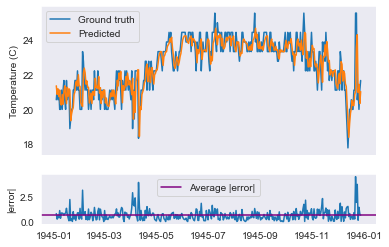

In [23]:
# model = Ridge(random_state=42)
model = MLPRegressor(hidden_layer_sizes=(10,10), activation='tanh', solver='lbfgs',
                           alpha=0.000, batch_size='auto', learning_rate='constant',learning_rate_init=0.01,
                           power_t=0.5, max_iter=10000, shuffle=True, momentum=0.0, nesterovs_momentum=False,
                           early_stopping=False, validation_fraction=0.0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

y_hat = pd.Series(y_hat, index=y_test.index)
error = y_test - y_hat

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(y_test, label="Ground truth")
ax[0].plot(y_hat, label="Predicted")
ax[0].set_ylabel("Temperature (C)")
ax[0].legend()
ax[0].grid()
ax[1].plot(error.abs())
ax[1].set_ylabel("|error|")
ax[1].axhline(error.abs().mean(), color="purple", label = "Average |error|")
ax[1].legend()
ax[1].grid()

In [24]:
f"The average |error| is: {error.abs().mean():.2f} +- {error.abs().std():.2f} degrees Celsius"

'The average |error| is: 0.65 +- 0.58 degrees Celsius'